In [2]:
import matplotlib.pyplot as plt

Actions each agent have to decide between: Leave or Stay 

In [3]:
import numpy as np

class Agent: 
    def __init__(self, music_taste = 1, strategy = 1, nr_concerts = 3, festival_duration=9):
        self.music_taste = music_taste
        self.position_utility = 0
        self.waiting_utility_history = np.zeros(festival_duration)
        self.strategy = strategy
        self.position_utility_history = np.zeros(festival_duration)
        self.concert_history = np.ones(festival_duration, dtype=int)*(nr_concerts-1)
        self.concert_history[0] = 0 #start at first concert 
    
class Concert:
    def __init__(self, len_rows = 1, music_type = 1, capacity = 5, duration = 2, nr_of_agents = 10):
        self.len_rows = len_rows
        self.music_type = music_type
        self.nr_agents = 0
        self.nr_waiting_agents = 0
        self.capacity = capacity
        self.nr_rows = np.ceil(capacity/len_rows)
        self.duration = duration #timesteps
        self.agents = np.zeros(nr_of_agents)

    def add_agent(self):
        self.nr_agents += 1

def get_placement_utility(concert):
    placement_factor = 5
    #continuing using sigmoid
    #fullness = concert.nr_agents / concert.capacity
    #sigmoid_x = 1 - fullness
    #k = 10 #steepness of sigomid
    #center = 0.5 #[0,1] with 0.1 happy crowd and 0.9 happy front row
    #utility = placement_factor * 1 / ( 1 + np.exp(-k*(sigmoid_x- center)))

    #stepwise by which row the agent is in, sensitive to concert row length
    dist_from_stage = np.floor((concert.nr_agents) / concert.len_rows)
    utility = placement_factor * (concert.nr_rows - dist_from_stage) / concert.nr_rows
    return utility

def get_waiting_utility():
    waiting_factor = 1
    utility = -1 * waiting_factor
    return utility



Strategies: Sart with defining strategies that do not depend on any history. Deterministic depending on which timestep it likes to leave

In [4]:
# Leaves at the timestep with 1
strategy_1 = [1,0,0,0,0]
strategy_2 = [0,1,0,0,0]
strategy_3 = [0,0,1,0,0]
strategy_4 = [0,0,0,1,0]
strategy_5 = [0,0,0,0,1]

strategy_dictionary = {
    1: strategy_1,
    2: strategy_2,
    3: strategy_3,
    4: strategy_4,
    5: strategy_5
}

def get_action(agent, timestep, maxtime):

    strategy = strategy_dictionary[agent.strategy]    
    if strategy[timestep] == 1:
        return "leave"
    else:
        return "stay"
        

Bigger functions used in simulation

In [5]:
def move_agent_to_next_concert(agent, idx, current_concert, next_concert, timestep, global_time):
    timesteps_left = current_concert.duration-timestep
    # Fill up agent's waiting utilities until the next concert
    idx_counter = 0
    for k in range(0,timesteps_left-1):
        agent.waiting_utility_history[global_time+k] = get_waiting_utility() + agent.waiting_utility_history[global_time+k -1]
        agent.position_utility_history[global_time+k] = agent.position_utility_history[global_time-1] 
        idx_counter += 1
    agent.waiting_utility_history[global_time + timesteps_left-1] = agent.waiting_utility_history[global_time+idx_counter-1]
    
    # Find position utility at next concert, add to history
    position_utility = get_placement_utility(next_concert)
    agent.position_utility = position_utility
    agent.position_utility_history[global_time + timesteps_left-1] = position_utility + \
    agent.position_utility_history[global_time-1]
    
    next_concert.add_agent() 
    next_concert.agents[idx] = 1

Inintialize variables

In [6]:
nr_of_agents = 5
nr_concerts = 10
concert_duration = 5
#strategies = [1, 5]
#probabilities = [0.9, 0.1]
strategies = [1, 2, 3, 4, 5]
nr_of_strategies = len(strategies)
#probabilities = [0.05, 0.05, 0.05, 0.8, 0.05]
probabilities = [0.2, 0.2, 0.2, 0.2, 0.2]
#probabilities = [0,0,0,0,1]

festival_duration = nr_concerts*concert_duration

In [7]:
def initialize_festival(probabilities):
    agents = []
    concerts = []

    for _ in range (nr_of_agents):
        strategy_sample = np.random.choice(strategies, p=probabilities)
        agents.append(Agent(music_taste=np.random.randint(1,4), strategy = strategy_sample, nr_concerts=nr_concerts, festival_duration = festival_duration))

    for _ in range(nr_concerts):
        concerts.append(Concert(music_type=np.random.randint(1,3), capacity = nr_of_agents, duration = concert_duration, nr_of_agents = nr_of_agents))

    #Add all agents to the starting concerts in a random order
    shuffled_indices = np.random.permutation(nr_of_agents)
    for i in range (nr_of_agents):
        idx = shuffled_indices[i]
        position_utility = 0 #Starting utility is zero
        concerts[0].add_agent() 
        concerts[0].agents[idx] = 1
        agents[idx].position_utility = position_utility
        agents[idx].accumulated_position_utility = position_utility
        concerts[0].add_agent() 

    return agents, concerts

#TODO All agents leaving during the same timestep must get the same utility

In [8]:
def simulate_one_festival(agents, concerts):

    global_time = 0
    for concert_idx in range(0,len(concerts)-1):
        current_concert = concerts[concert_idx]
        next_concert = concerts[concert_idx + 1]
        #next_next_concert = concerts[ i + 2]

        for timestep in range(0,current_concert.duration):
            # Update time
            global_time += 1
            shuffled_indices = np.random.permutation(nr_of_agents)
            for j in range (nr_of_agents):
                idx = shuffled_indices[j]
                
                if (current_concert.agents[idx] == 0):  
                    # Not attending the concert 
                    continue
                
                action = get_action(agents[idx],timestep, current_concert.duration)
                
                if (action == 'leave'):
                    # Leave current concert
                    current_concert.agents[idx] = 0
                    
                    for k in range(0,current_concert.duration-timestep):
                        #Update agent's concert history
                        agents[idx].concert_history[global_time + k] = concert_idx + 1

                    # Set agent up at the next concert
                    move_agent_to_next_concert(agents[idx], idx, current_concert, next_concert, timestep, global_time)
                    
                else: #they stay at the concert one more time step
                    # Improve position utility
                    agents[idx].position_utility_history[global_time] = agents[idx].position_utility_history[global_time-1] + \
                    agents[idx].position_utility
                    # Leave waiting utility unchanged
                    agents[idx].waiting_utility_history[global_time] = agents[idx].waiting_utility_history[global_time - 1]
                    
                    #Update agent's concert history
                    agents[idx].concert_history[global_time] = concert_idx 
                    
        # Let all agents stay at the last concert
        if (concert_idx == nr_concerts-2):
            for agent in agents:
                for k in range(0,next_concert.duration):
                    agent.position_utility_history[global_time+k] = agent.position_utility_history[global_time+k-1] + \
                    agent.position_utility
                    agent.waiting_utility_history[global_time+k] = agent.waiting_utility_history[global_time - 1]

    
    # for evolutionary: need average utility for all agents and for each strategy
    return agents

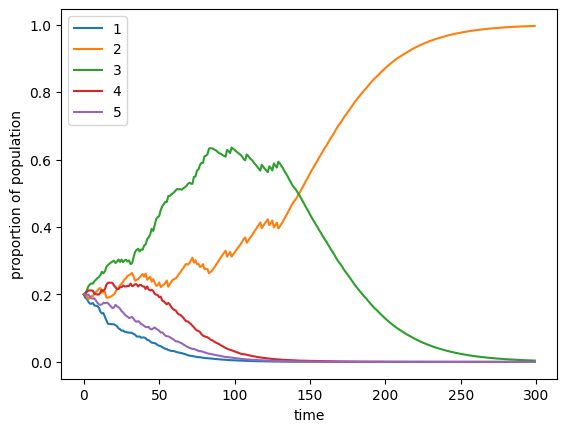

In [55]:
nr_iterations = 300
r_value = 0.001 # what value?
population_proportions = np.zeros((nr_of_strategies, nr_iterations))
population_proportions[:,0] = probabilities

for t in range(1,nr_iterations):

    # initialize festival 
    #print(population_proportions[:,t-1])
    agents, concerts = initialize_festival(population_proportions[:,t-1])

    # simulate festival
    agents = simulate_one_festival(agents, concerts)

    # get average utilities for all agents
    average_utility = 0
    for agent in agents:
        average_utility += agent.position_utility_history[-1] + agent.waiting_utility_history[-1]
    average_utility = average_utility / nr_of_agents
    #print(average_utility)

    # get average utility for each strategy
    agents_by_strategy = {strategy: [agent for agent in agents if agent.strategy == strategy] for strategy in strategies}
    average_utility_per_strategy = np.zeros(nr_of_strategies)

    for strategy, agent_list in agents_by_strategy.items():
        for agent in agent_list:
            average_utility_per_strategy[strategy - 1] += agent.position_utility_history[-1] + agent.waiting_utility_history[-1]
        if (len(agent_list) > 0):
            average_utility_per_strategy[strategy - 1] = average_utility_per_strategy[strategy -1] / len(agent_list)
    
    # update population_proportions
    delta_population = r_value * population_proportions[:,t-1] * (average_utility_per_strategy - average_utility)
    population_proportions[:,t] = population_proportions[:,t-1] + delta_population


    for i, value in enumerate(population_proportions[:,t]):
        population_proportions[i,t] = np.max([0, value])
    
    scale_factor = 1 / sum(population_proportions[:,t])

    population_proportions[:,t] *= scale_factor

# print evolution
fig, axes = plt.subplots(1,1)
timesteps_plot = np.arange(nr_iterations)
for i in range(nr_of_strategies):
    axes.plot(timesteps_plot,population_proportions[i,:], label = i + 1)

axes.set_xlabel("time")
axes.set_ylabel("proportion of population")
axes.legend()
plt.show()

In [ ]:
# idx = 1
# print("Strategy: ", agents[idx].strategy)
# print("Total time steps: ", len(agents[idx].concert_history), ", Concert duration: ", concert_duration, ", Nr of concerts: ", len(concerts))
# print("Arena at each timestp: ", agents[idx].concert_history)
# print("Waiting utility history: ", agents[idx].waiting_utility_history)
# print("Position utility history: ", agents[idx].position_utility_history)

Some basic plots of how utility change with time

Proportions of each class [0.2, 0.2, 0.2, 0.2, 0.2]


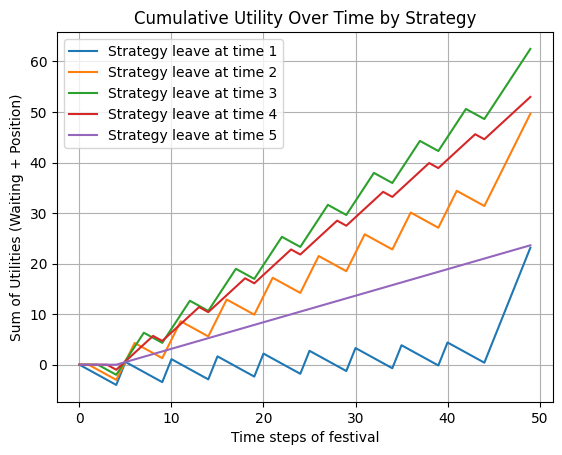

In [ ]:

import numpy as np

# Group agents by strategy
agents_by_strategy = {strategy: [agent for agent in agents if agent.strategy == strategy] for strategy in strategies}

# Initialize sum of utilities for each strategy
sum_utilities = {strategy: np.zeros(festival_duration) for strategy in strategies}

# Calculate cumulative utilities for each strategy
for strategy, agent_list in agents_by_strategy.items():
    for agent in agent_list:
        sum_utilities[strategy] += agent.waiting_utility_history + agent.position_utility_history
    if len(agent_list) > 0:  # Normalize only if there are agents with this strategy
        sum_utilities[strategy] /= len(agent_list)

# Plot the utilities
timesteps = np.arange(festival_duration)
for strategy, utility in sum_utilities.items():
    plt.plot(timesteps, utility, label=f"Strategy leave at time {strategy}")

print("Proportions of each class", probabilities)

# Configure the plot
plt.xlabel("Time steps of festival")
plt.ylabel("Sum of Utilities (Waiting + Position)")
plt.title("Cumulative Utility Over Time by Strategy")
plt.legend()
plt.grid(True)
plt.show()


How did the simulation go?

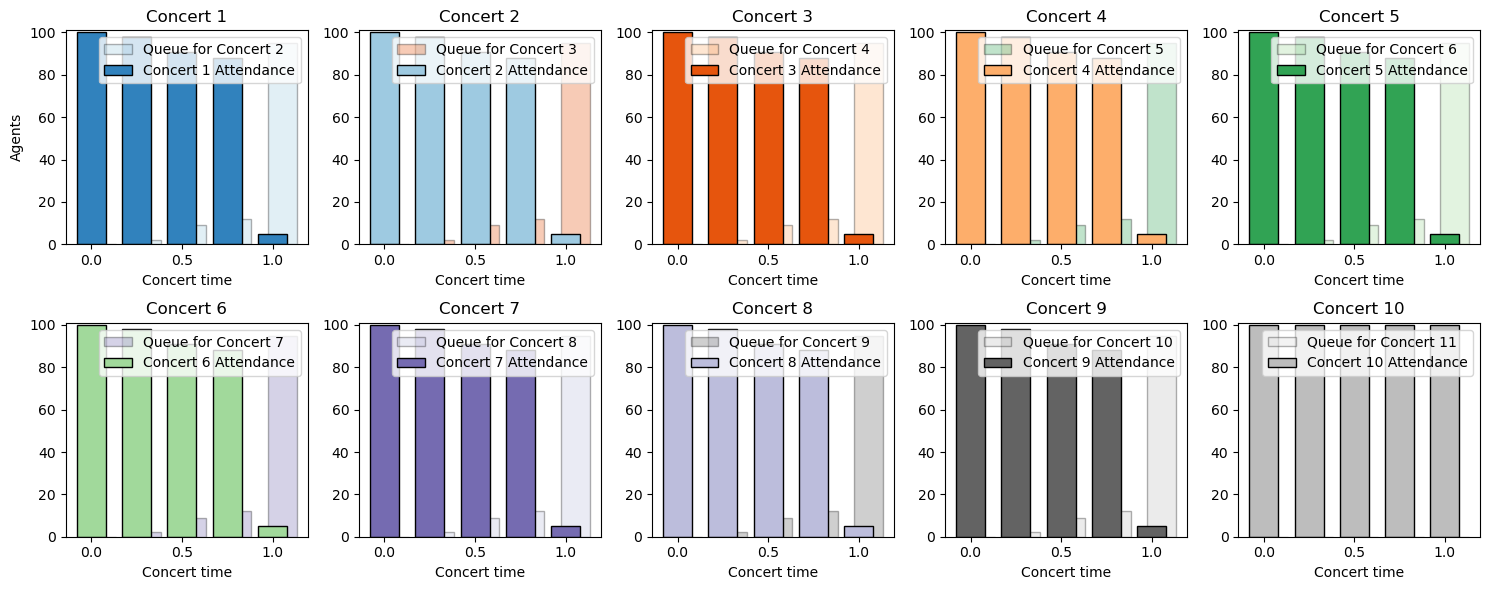

In [ ]:
from graphs import BarGraph
A = np.zeros([nr_concerts, int(festival_duration)])

agent_concert = []

# Make dataset
for agent in agents:
    agent_concert.append(agent.concert_history)

for agent in agent_concert:
    t = 0
    for i in agent:
        A[i, t] += 1
        t += 1

graph = BarGraph(A)
graph.plot_data(5)

Some stuff that is sad to delete

In [ ]:
 # elif (action == 'skip'):
            #     agents[idx].position_history.append(agents[idx].accumulated_position_utility) #rätt tillfälle?
            #     agents[idx].waiting_utility_history += get_waiting_utility(next_next_concert.duration)
            #     position_utility = get_placement_utility(next_next_concert)
            #     next_next_concert.add_agent() 
            #     next_next_concert.agents[idx] = 1
            #     agents[idx].position_utility = position_utility
            #     agents[idx].accumulated_position_utility = position_utility
            #     current_concert.agents[idx] = 0
            #     #Update agent's concert history
            #     agents[idx].concert_history.append(i+2) #does not work

In [ ]:
# def get_action_2(agent, timestep, max_time):
#     # Stay at the consert
#     if (agent.strategy == 1):
#         if (timestep == max_time - 1):
#             action = 'leave'
#         else:
#             action = 'stay'
        
#     # Leave to the next concert as early as possible
#     if (agent.strategy == 2):
#         if (timestep == 0):
#             action = 'leave'
#         else:
#             print("Leaving agent stayed")

#     # Gows in the middle of the concert
#     if (agent.strategy == 3):
#         if (timestep == np.round(max_time/2)):
#             action = 'leave'
#         else:
#             action = 'stay'

#     return action

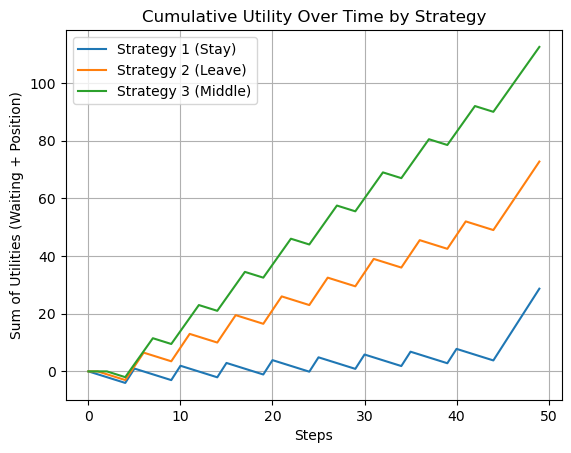

In [ ]:
import matplotlib.pyplot as plt

agents_strategy_stay = [agent for agent in agents if agent.strategy == 1]
agents_strategy_leave = [agent for agent in agents if agent.strategy == 2]
agents_strategy_middle = [agent for agent in agents if agent.strategy == 3]

timesteps = np.arange(festival_duration)
sum_utility_stay = np.zeros(festival_duration)
sum_utility_leave = np.zeros(festival_duration)
sum_utility_middle = np.zeros(festival_duration)

# Sum utilities for strategy 1 (stay)
for agent in agents_strategy_stay:
    sum_utility_stay += agent.waiting_utility_history + agent.position_utility_history
sum_utility_stay = sum_utility_stay / len(agents_strategy_stay) #normalise

# Sum utilities for strategy 2 (leave)
for agent in agents_strategy_leave:
    sum_utility_leave += agent.waiting_utility_history + agent.position_utility_history
sum_utility_leave = sum_utility_leave / len(agents_strategy_leave)

# Sum startegy 3 (go in the middle)
for agent in agents_strategy_middle:
    sum_utility_middle += agent.waiting_utility_history + agent.position_utility_history
sum_utility_middle = sum_utility_middle / len(agents_strategy_middle)

plt.plot(timesteps, sum_utility_stay, label="Strategy 1 (Stay)")
plt.plot(timesteps, sum_utility_leave, label="Strategy 2 (Leave)")
plt.plot(timesteps, sum_utility_middle, label="Strategy 3 (Middle)")
plt.xlabel("Steps")
plt.ylabel("Sum of Utilities (Waiting + Position)")
plt.title("Cumulative Utility Over Time by Strategy")
plt.legend()
plt.grid(True)
plt.show()